# Step 1: Data Preprocessing

In [ ]:
#imports
import os
import cv2
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import layers
from tensorflow.python.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization, Activation, Dropout, Concatenate
from tensorflow.python.keras import Model, Input
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.resnet50 import ResNet50

from skimage import io
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

%matplotlib inline

First, the dataset must be imported from my Google Drive.

In [32]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [33]:
!unzip gdrive/My\ Drive/data/data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/train/no-damage/palu-tsunami_00000043_pre_disaster.png  
  inflating: data/train/no-damage/socal-fire_00000126_pre_disaster.png  
  inflating: data/train/no-damage/socal-fire_00000723_pre_disaster.png  
  inflating: data/train/no-damage/socal-fire_00000520_pre_disaster.png  
  inflating: data/train/no-damage/midwest-flooding_00000399_pre_disaster.png  
  inflating: data/train/no-damage/socal-fire_00000107_pre_disaster.png  
  inflating: data/train/no-damage/midwest-flooding_00000360_pre_disaster.png  
  inflating: data/train/no-damage/socal-fire_00000501_pre_disaster.png  
  inflating: data/train/no-damage/guatemala-volcano_00000000_pre_disaster.png  
  inflating: data/train/no-damage/midwest-flooding_00000386_pre_disaster.png  
  inflating: data/train/no-damage/mexico-earthquake_00000132_pre_disaster.png  
  inflating: data/train/no-damage/santa-rosa-wildfire_00000125_pre_disaster.png  
  inflating: data/train/no-dam

## Organizing the Data

After downloading the dataset onto my hard drive, I reorganized it to better suit the classification model I wished to build. The data was already split into training, validation and testing groups. I further organized each group into `damage` and `no-damage` categories, corresponding to the two class labels. The function I wrote to complete this step is below.

```
def organize_data():
    
    """ Split the data into a training group and testing group. Each group will be 
    organized into damage and non-damage folders, corresponding to the two class labels.
    """
     
    for file in os.listdir('data/raw-train-data'):
        
        if file.endswith('pre_disaster.png'):         
            src = 'data/raw-train-data/' + file 
            shutil.copy(src, 'data/train/no-damage')
    
        elif file.endswith('post_disaster.png'):
            src = 'data/raw-train-data/' + file  
            shutil.copy(src, 'data/train/damage')
        
        else: 
            src = 'data/raw-train-data/' + file  
            shutil.copy(src, 'data/train/other')
    
    print("DONE PROCESSING TRAINING IMGS")
      
    for file in os.listdir('data/raw-test-data'):
    
        if file.endswith('pre_disaster.png'):      
            src = 'data/raw-test-data/' + file
            shutil.copy(src, 'data/test/no-damage')
        
        elif file.endswith('post_disaster.png'): 
            src = 'data/raw-test-data/' + file
            shutil.copy(src, 'data/test/damage')
        
        else: 
            src = 'data/raw-test-data/' + file
            shutil.copy(src, 'data/test/other')

    print("DONE PROCESSING TESTING IMGS")  

    for file in os.listdir('data/raw-valid-data'):
        
        if file.endswith('pre_disaster.png'):      
            src = 'data/raw-valid-data/' + file
            shutil.copy(src, 'data/valid/no-damage')
        
        elif file.endswith('post_disaster.png'): 
            src = 'data/raw-valid-data/' + file
            shutil.copy(src, 'data/valid/damage')
        
        else: 
            src = 'data/raw-valid-data/' + file
            shutil.copy(src, 'data/valid/other')

    print("DONE PROCESSING VALIDATION IMGS")   
```





## Image Compression

In order to upload the dataset to my Google Drive, its size had to be significantly reduced, as each image had a 1,024 x 1,024 resolution. After much experimentation, I found that compressing each image to 512 x 512 pixels greatly reduced the dataset size while also retaining the fine details of the original satellite imagery. This appraoch also allowed me to preserve all the data, so nothing had to be deleted. The function I wrote to compress the images is below. It should be noted that this step, as well as the previous step, were done on my local machine due the large size of the dataset. This step, in particular, was an effort to shrink the dataset size so I could upload and download it efficiently. 

```
def compress_data():
    
    """ Compress each image file to 512x512 pixels. """
    
    for file in os.listdir('data/train/damage'):
        
        src = 'data/train/damage/' + file 
        img = Image.open(src)
        img = img.resize((512,512), Image.ANTIALIAS)
        
        dst = 'processed-data/train/damage/' + file
        img.save(dst, optimize=True, quality=95)
    
    for file in os.listdir('data/train/no-damage'):   
        
        src = 'data/train/no-damage/' + file 
        img = Image.open(src)
        img = img.resize((512,512), Image.ANTIALIAS)
        
        dst = 'processed-data/train/no-damage/' + file
        img.save(dst, optimize=True, quality=95) 
    
    for file in os.listdir('data/test/damage'):
        
        src = 'data/test/damage/' + file 
        img = Image.open(src)
        img = img.resize((512,512), Image.ANTIALIAS)
        
        dst = 'processed-data/test/damage/' + file
        img.save(dst, optimize=True, quality=95) 
        
    for file in os.listdir('data/test/no-damage'):
        
        src = 'data/test/no-damage/' + file 
        img = Image.open(src)
        img = img.resize((512,512), Image.ANTIALIAS)
        
        dst = 'processed-data/test/no-damage/' + file
        img.save(dst, optimize=True, quality=95)

    for file in os.listdir('data/valid/damage'):
            
        src = 'data/valid/damage/' + file 
        img = Image.open(src)
        img = img.resize((512,512), Image.ANTIALIAS)
        
        dst = 'processed-data/valid/damage/' + file
        img.save(dst, optimize=True, quality=95)  
     
    for file in os.listdir('data/valid/no-damage'):
            
        src = 'data/valid/no-damage/' + file 
        img = Image.open(src)
        img = img.resize((512,512), Image.ANTIALIAS)
        
        dst = 'processed-data/valid/no-damage/' + file
        img.save(dst, optimize=True, quality=95)

```




## Overview of Dataset

Now, we can begin our exploratory data analysis. Let's first look at the structure of the dataset. As mentioned before, the images are seperated into training, validation and testing groups. Each group is organized into `damage` and `no-damage` categories, corresponding to the two class labels. For the training set, there are 2,799 images in the `no-damage` class and 2,799 images in the `damage` class. For the validation set, there are 933 images in the `no-damage` class and 933 in the `damage` class. And lastly, for the testing set, there are 933 images in the `no-damage` class and 933 in the `damage` class.

In [ ]:
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)

list_files('data')

In [ ]:
DIR = '/content/data'

# number of images per class in training set
print('-------TRAIN-------')
print(f"No Damage: {len(os.listdir(os.path.join(DIR, 'train', 'no-damage')))}")
print(f"Damage: {len(os.listdir(os.path.join(DIR, 'train', 'damage')))}")

# number of images per class in validation set
print('-----VALIDATION-----')
print(f"No Damage: {len(os.listdir(os.path.join(DIR, 'valid', 'no-damage')))}")
print(f"Damage: {len(os.listdir(os.path.join(DIR, 'valid', 'damage')))}")

# number of images per class in testing set
print('--------TEST--------')
print(f"No Damage: {len(os.listdir(os.path.join(DIR, 'test', 'no-damage')))}")
print(f"Damage: {len(os.listdir(os.path.join(DIR, 'test', 'damage')))}")


-------TRAIN-------
No Damage: 2799
Damage: 2799
-----VALIDATION-----
No Damage: 933
Damage: 933
--------TEST--------
No Damage: 933
Damage: 933


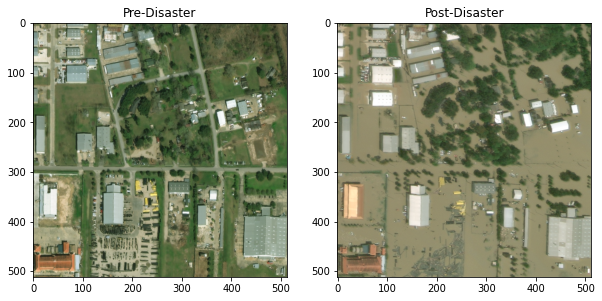

In [ ]:
# load sample images
tile_path1 = os.path.join(DIR, 'train', 'no-damage' , 'hurricane-harvey_00000114_pre_disaster.png')
tile1 = io.imread(tile_path1)

tile_path2 = os.path.join(DIR, 'train', 'damage' , 'hurricane-harvey_00000114_post_disaster.png')
tile2 = io.imread(tile_path2)

# plot pre-disaster image
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 2, 1)
plt.imshow(tile1)
plt.title("Pre-Disaster")
  
# splot post-disaster image
fig.add_subplot(1, 2, 2)
plt.imshow(tile2)
plt.title("Post-Disaster");


Each image in the dataset is in RBG format, with 3 channels representing the R, G and B color values.

In [49]:
tile1.shape

(512, 512, 4)

 In each set, we can see that the classes are balanced.

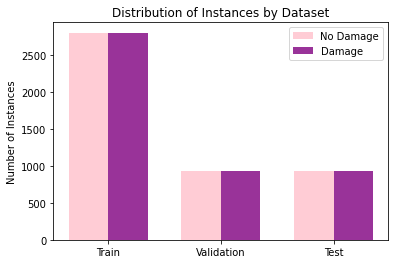

In [50]:
# data to plot
n_groups = 3
no_damage = (len(os.listdir(os.path.join(DIR, 'train', 'no-damage'))), len(os.listdir(os.path.join(DIR, 'valid', 'no-damage'))), len(os.listdir(os.path.join(DIR, 'test', 'no-damage'))))
damage = (len(os.listdir(os.path.join(DIR, 'train', 'damage'))), len(os.listdir(os.path.join(DIR, 'valid', 'damage'))), len(os.listdir(os.path.join(DIR, 'test', 'damage'))))

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, no_damage, bar_width,
alpha=opacity,
color='pink',
label='No Damage')

rects2 = plt.bar(index + bar_width, damage, bar_width,
alpha=opacity,
color='purple',
label='Damage')

plt.ylabel('Number of Instances')
plt.title('Distribution of Instances by Dataset')
plt.xticks(index + bar_width/2, ('Train', 'Validation', 'Test'))
plt.legend()
plt.show()

# Step 2: Modeling

I will now train a series of convolutional neural networks and evaluate their performance on validation data. This approach is based off the work done by Kapoor in his damage detection models for Hurricane Harvey. I am following the same structure, but my models will be trained on satellite images from various natural disasters across the world, making them generalizable to future events. The models are described below.

1. A model with 3 convolution layers and 3 dense layers
2. Model 1, with max pooling layers added
3. Model 2, with dropout layers added

All models are evaluated based on validation accuracy. Training is for 50 epochs with early stopping if the model does not improve after 10 epochs. The weights for the best performing epoch are then saved.

In [51]:
# paths
DIR = ('/content/data/')
train_path = os.path.join(DIR, 'train')
val_path = os.path.join(DIR, 'valid')
test_path = os.path.join(DIR, 'test')

## Model 1

I first created a baseline model with three convolution
layers, three dense layers and an output layer with 2 nodes,
corresponding to the two classes. This is the same
architecture that Kapoor used for his baseline model in his research. The model achieved an accuracy of 0.66131 on validation data.


In [52]:
image_size = (512, 512)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_path,
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

Found 5598 files belonging to 2 classes.
Found 1866 files belonging to 2 classes.


In [ ]:
# define model
model1 = keras.Sequential([
   
   # rescale the input in the [0, 255] range to be in the [0, 1] range
   keras.layers.Rescaling(1.0 / 255), 
   
   # convolutional layers
   keras.layers.Conv2D(32, kernel_size=5, strides=2, padding='same', input_shape=(512,512,3)), 
   keras.layers.BatchNormalization(), # use Batch Normalization to make training faster and more stable through the normalization of the layers
   keras.layers.Activation('relu'), 

   keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(512,512,3)),
   keras.layers.BatchNormalization(),
   keras.layers.Activation('relu'),
   
   keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(512,512,3)),
   keras.layers.BatchNormalization(),
   keras.layers.Activation('relu'),
   
   # flatten the data
   keras.layers.Flatten(),

   # dense layers
   keras.layers.Dense(1024,activation='relu'),
   keras.layers.Dense(512,activation='relu'),
   keras.layers.Dense(256, activation='relu'),
   
   # output layer
   keras.layers.Dense(2, activation='softmax')
   
])

# define optimizer, loss function, and evaluation metric
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)

# save best model
mc = ModelCheckpoint('models/Model1/best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# train the model
model1.fit(train_ds, epochs=50, callbacks=[es, mc], validation_data=val_ds)

Epoch 1/50
175/175 [==============================] - ETA: 0s - loss: 7.9433 - accuracy: 0.5011
Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to models/Model1/best_model.h5
175/175 [==============================] - 33s 133ms/step - loss: 7.9433 - accuracy: 0.5011 - val_loss: 0.8058 - val_accuracy: 0.5000
Epoch 2/50
175/175 [==============================] - ETA: 0s - loss: 0.7930 - accuracy: 0.5604
Epoch 00002: val_accuracy did not improve from 0.50000
175/175 [==============================] - 16s 89ms/step - loss: 0.7930 - accuracy: 0.5604 - val_loss: 0.7358 - val_accuracy: 0.4727
Epoch 3/50
175/175 [==============================] - ETA: 0s - loss: 0.6774 - accuracy: 0.6495
Epoch 00003: val_accuracy improved from 0.50000 to 0.50054, saving model to models/Model1/best_model.h5
175/175 [==============================] - 26s 145ms/step - loss: 0.6774 - accuracy: 0.6495 - val_loss: 1.1071 - val_accuracy: 0.5005
Epoch 4/50
175/175 [==============================]

## Model 2

In the following model, max pooling layers are added after each colvintion layer to reduce the spatial dimensions of the output volume. This generalizes the features detected in an image, thus reducing the sensitivity of the model. The model achieved an accuracy of 0.84137 on validation data, which is a substantial improvement from the previous iteration.


In [ ]:
# define model
model2 = keras.Sequential([
   
   # rescale the input in the [0, 255] range to be in the [0, 1] range
   keras.layers.Rescaling(1.0 / 255), 
   
   # convolutional layers
   keras.layers.Conv2D(32, kernel_size=5, strides=2, padding='same', input_shape=(512,512,3)), 
   keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None), # added Max Pooling layer
   keras.layers.BatchNormalization(), 
   keras.layers.Activation('relu'), 

   keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(512,512,3)),
   keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None), # added Max Pooling layer
   keras.layers.BatchNormalization(),
   keras.layers.Activation('relu'),
   
   keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(512,512,3)),
   keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None), # added Max Pooling layer
   keras.layers.BatchNormalization(),
   keras.layers.Activation('relu'),
   
   # flatten the data
   keras.layers.Flatten(),

   # dense layers
   keras.layers.Dense(1024,activation='relu'),
   keras.layers.Dense(512,activation='relu'),
   keras.layers.Dense(256, activation='relu'),
   
   # output layer
   keras.layers.Dense(2, activation='softmax')
   
])

# define optimizer, loss function, and evaluation metric
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)

# save best model
mc = ModelCheckpoint('models/Model2/best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# train the model
model2.fit(train_ds, epochs=50, callbacks=[es, mc], validation_data=val_ds)

Epoch 1/50
175/175 [==============================] - ETA: 0s - loss: 0.6908 - accuracy: 0.6122
Epoch 00001: val_accuracy improved from -inf to 0.52787, saving model to models/Model2/best_model.h5
175/175 [==============================] - 12s 65ms/step - loss: 0.6908 - accuracy: 0.6122 - val_loss: 0.6968 - val_accuracy: 0.5279
Epoch 2/50
175/175 [==============================] - ETA: 0s - loss: 0.5516 - accuracy: 0.7051
Epoch 00002: val_accuracy improved from 0.52787 to 0.55788, saving model to models/Model2/best_model.h5
175/175 [==============================] - 11s 62ms/step - loss: 0.5516 - accuracy: 0.7051 - val_loss: 0.7305 - val_accuracy: 0.5579
Epoch 3/50
174/175 [============================>.] - ETA: 0s - loss: 0.4979 - accuracy: 0.7430
Epoch 00003: val_accuracy did not improve from 0.55788
175/175 [==============================] - 11s 62ms/step - loss: 0.4980 - accuracy: 0.7426 - val_loss: 0.9704 - val_accuracy: 0.5150
Epoch 4/50
175/175 [==============================] -

## Model 3

To further improve the model, I add dropout layers added after each dense layer. Dropout layers offer a very computationally cheap and remarkably effective regularization method to reduce overfitting and improve generalization error in a model. The model below achieved a validation accuracy of 0.85959, which is an improvement from the previous iteration.

In [ ]:
# define model
model3 = keras.Sequential([
   
   # rescale the input in the [0, 255] range to be in the [0, 1] range
   keras.layers.Rescaling(1.0 / 255), 
   
   # convolutional layers
   keras.layers.Conv2D(32, kernel_size=5, strides=2, padding='same', input_shape=(512,512,3)),
   keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None),
   keras.layers.BatchNormalization(),
   keras.layers.Activation('relu'),

   keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(512,512,3)),
   keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None),
   keras.layers.BatchNormalization(),
   keras.layers.Activation('relu'),
   
   keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(512,512,3)),
   keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None),
   keras.layers.BatchNormalization(),
   keras.layers.Activation('relu'),
   
   # flatten the data
   keras.layers.Flatten(),

   # dense layers
   keras.layers.Dense(1024,activation='relu'),
   keras.layers.Dropout(0.5), # added dropout layer
   keras.layers.Dense(512,activation='relu'),
   keras.layers.Dropout(0.3), # added dropout layer
   keras.layers.Dense(256, activation='relu'),
   keras.layers.Dropout(0.1),  # added dropout layer
   
   # output layer
   keras.layers.Dense(2, activation='softmax')

])

# define optimizer, loss function, and evaluation metric
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)

# save best model
mc = ModelCheckpoint('models/Model3/best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# train the model
model3.fit(train_ds, epochs=50, callbacks=[es, mc], validation_data=val_ds)

Epoch 1/50
175/175 [==============================] - ETA: 0s - loss: 0.8164 - accuracy: 0.5279
Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to models/Model3/best_model.h5
175/175 [==============================] - 13s 65ms/step - loss: 0.8164 - accuracy: 0.5279 - val_loss: 0.7289 - val_accuracy: 0.5000
Epoch 2/50
175/175 [==============================] - ETA: 0s - loss: 0.6153 - accuracy: 0.6511
Epoch 00002: val_accuracy improved from 0.50000 to 0.53912, saving model to models/Model3/best_model.h5
175/175 [==============================] - 11s 63ms/step - loss: 0.6153 - accuracy: 0.6511 - val_loss: 0.8293 - val_accuracy: 0.5391
Epoch 3/50
174/175 [============================>.] - ETA: 0s - loss: 0.5695 - accuracy: 0.6950
Epoch 00003: val_accuracy did not improve from 0.53912
175/175 [==============================] - 11s 63ms/step - loss: 0.5688 - accuracy: 0.6952 - val_loss: 1.5632 - val_accuracy: 0.5005
Epoch 4/50
175/175 [==============================] -

# Step 3: Improving Model Performance

I will now experiment with various hyperparameters to improve model perfomance. From this, I learn that decreasing the convolutional kernel size and reducing the number of nodes in the dense layers by 50% increases performance. The models achieve a much higher accuracy than the baseline models, but are unfortunately not converging, which suggests lack of generalizability. 

Below is a function written by Kappor which plots the training accuracy, validation accuracy and loss over all epochs. This enables me to inspect the training process visually. If training accuracy increases close to 1.0 but validation accuracy stays poor, I will know the model is overfitting.

In [59]:
def plot_training(history):
    
    ''' Given model training history, plots validation accuracy and loss. '''
    
    # plot history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


### Convolutional Kernel Size

Below, I decrease the convolutional kernel size from 5x5 to 3x3. This achieved a validation accuracy of 0.86817, which is an improvement from the previous iternation.

In [ ]:
# define model
model4 = keras.Sequential([
   
   # rescale the input in the [0, 255] range to be in the [0, 1] range
   keras.layers.Rescaling(1.0 / 255), 
   
   # convolutional layers
   keras.layers.Conv2D(32, kernel_size=3, strides=2, padding='same', input_shape=(512,512,3)),
   keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None),
   keras.layers.BatchNormalization(),
   keras.layers.Activation('relu'),

   keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(512,512,3)),
   keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None),
   keras.layers.BatchNormalization(),
   keras.layers.Activation('relu'),
   
   keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(512,512,3)),
   keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None),
   keras.layers.BatchNormalization(),
   keras.layers.Activation('relu'),
   
   # flatten the data
   keras.layers.Flatten(),

   # dense layers
   keras.layers.Dense(1024,activation='relu'),
   keras.layers.Dropout(0.5), 
   keras.layers.Dense(512,activation='relu'),
   keras.layers.Dropout(0.3), 
   keras.layers.Dense(256, activation='relu'),
   keras.layers.Dropout(0.1),  
   
   # output layer
   keras.layers.Dense(2, activation='softmax')

])

# define optimizer, loss function, and evaluation metric
model4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)

# save best model
mc = ModelCheckpoint('models/Model4/best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# train the model
results4 = model4.fit(train_ds, epochs=50, callbacks=[es, mc], validation_data=val_ds)

Epoch 1/50
175/175 [==============================] - ETA: 0s - loss: 0.7944 - accuracy: 0.5556
Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to models/Model4/best_model.h5
175/175 [==============================] - 12s 64ms/step - loss: 0.7944 - accuracy: 0.5556 - val_loss: 0.7979 - val_accuracy: 0.5000
Epoch 2/50
174/175 [============================>.] - ETA: 0s - loss: 0.5705 - accuracy: 0.6990
Epoch 00002: val_accuracy did not improve from 0.50000
175/175 [==============================] - 11s 62ms/step - loss: 0.5703 - accuracy: 0.6988 - val_loss: 1.0956 - val_accuracy: 0.4989
Epoch 3/50
175/175 [==============================] - ETA: 0s - loss: 0.5261 - accuracy: 0.7385
Epoch 00003: val_accuracy improved from 0.50000 to 0.62272, saving model to models/Model4/best_model.h5
175/175 [==============================] - 11s 62ms/step - loss: 0.5261 - accuracy: 0.7385 - val_loss: 0.6417 - val_accuracy: 0.6227
Epoch 4/50
174/175 [============================>.] -

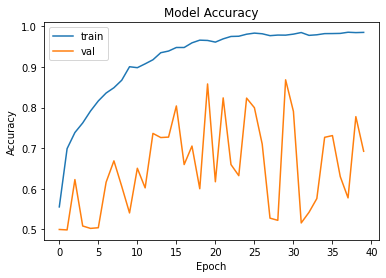

In [ ]:
plot_training(results4)

### Less Dense Nodes

Below, I decrease the number of nodes in the dense layers. This achieved a validation accuracy of 0.88264, which is an improvement from the previous model.

In [ ]:
# define model
model5 = keras.Sequential([
   
   # rescale the input in the [0, 255] range to be in the [0, 1] range
   keras.layers.Rescaling(1.0 / 255), 
   
   # convolutional layers
   keras.layers.Conv2D(32, kernel_size=3, strides=2, padding='same', input_shape=(512,512,3)),
   keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None),
   keras.layers.BatchNormalization(),
   keras.layers.Activation('relu'),

   keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(512,512,3)),
   keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None),
   keras.layers.BatchNormalization(),
   keras.layers.Activation('relu'),
   
   keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(512,512,3)),
   keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None),
   keras.layers.BatchNormalization(),
   keras.layers.Activation('relu'),
   
   # flatten the data
   keras.layers.Flatten(),

   # dense layers
   keras.layers.Dense(512,activation='relu'),
   keras.layers.Dropout(0.5), 
   keras.layers.Dense(256,activation='relu'),
   keras.layers.Dropout(0.3), 
   keras.layers.Dense(128, activation='relu'),
   keras.layers.Dropout(0.1),  
   
   # output layer
   keras.layers.Dense(2, activation='softmax')

])

# define optimizer, loss function, and evaluation metric
model5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)

# save best model
mc = ModelCheckpoint('models/Model5/best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# train the model
results5 = model5.fit(train_ds, epochs=50, callbacks=[es, mc], validation_data=val_ds)

Epoch 1/50
175/175 [==============================] - ETA: 0s - loss: 0.8244 - accuracy: 0.5088
Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to models/Model5/best_model.h5
175/175 [==============================] - 12s 62ms/step - loss: 0.8244 - accuracy: 0.5088 - val_loss: 0.6989 - val_accuracy: 0.5000
Epoch 2/50
175/175 [==============================] - ETA: 0s - loss: 0.5947 - accuracy: 0.6754
Epoch 00002: val_accuracy improved from 0.50000 to 0.55895, saving model to models/Model5/best_model.h5
175/175 [==============================] - 11s 62ms/step - loss: 0.5947 - accuracy: 0.6754 - val_loss: 0.6746 - val_accuracy: 0.5589
Epoch 3/50
175/175 [==============================] - ETA: 0s - loss: 0.5501 - accuracy: 0.7172
Epoch 00003: val_accuracy did not improve from 0.55895
175/175 [==============================] - 11s 61ms/step - loss: 0.5501 - accuracy: 0.7172 - val_loss: 0.8520 - val_accuracy: 0.5364
Epoch 4/50
174/175 [============================>.] -

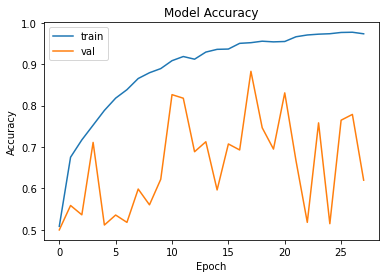

In [ ]:
plot_training(results5)

### Final Model

While most of the models above performed relatively
well, a recurring issue was that models would achieve high
accuracy after only a few training epochs and never converge. This lack of convergence suggests that the models may not be generalizable to the test set and other unseen data. However, during experimentation, I discovered adding a dense layer with 1,024 nodes, followed by a dropout layer with a 0.7 dropout rate, results in an accuracy of 0.9239.

In [57]:
# define model
model6 = keras.Sequential([
   
   # rescale the input in the [0, 255] range to be in the [0, 1] range
   keras.layers.Rescaling(1.0 / 255), 
   
   # convolutional layers
   keras.layers.Conv2D(32, kernel_size=3, strides=2, padding='same', input_shape=(512,512,3)),
   keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None),
   keras.layers.BatchNormalization(),
   keras.layers.Activation('relu'),

   keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same'),
   keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None),
   keras.layers.BatchNormalization(),
   keras.layers.Activation('relu'),
   
   keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same'),
   keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None),
   keras.layers.BatchNormalization(),
   keras.layers.Activation('relu'),
   
   # flatten the data
   keras.layers.Flatten(),

   # dense layers
   keras.layers.Dense(1024,activation='relu'),
   keras.layers.Dropout(0.7), 
   keras.layers.Dense(512,activation='relu'),
   keras.layers.Dropout(0.5), 
   keras.layers.Dense(256,activation='relu'),
   keras.layers.Dropout(0.3), 
   keras.layers.Dense(128, activation='relu'),
   keras.layers.Dropout(0.1),  
   
   # output layer
   keras.layers.Dense(2, activation='softmax')

])

# define optimizer, loss function, and evaluation metric
model6.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)

# save best model
mc = ModelCheckpoint('models/Model6/best_model_3.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# train the model
results6 = model6.fit(train_ds, epochs=100, callbacks=[es, mc], validation_data=val_ds)

Epoch 1/100
175/175 [==============================] - ETA: 0s - loss: 0.9237 - accuracy: 0.4916
Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to models/Model6/best_model_3.h5
175/175 [==============================] - 12s 64ms/step - loss: 0.9237 - accuracy: 0.4916 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 2/100
175/175 [==============================] - ETA: 0s - loss: 0.7106 - accuracy: 0.4943
Epoch 00002: val_accuracy did not improve from 0.50000
175/175 [==============================] - 11s 63ms/step - loss: 0.7106 - accuracy: 0.4943 - val_loss: 0.6953 - val_accuracy: 0.5000
Epoch 3/100
175/175 [==============================] - ETA: 0s - loss: 0.7026 - accuracy: 0.5020
Epoch 00003: val_accuracy did not improve from 0.50000
175/175 [==============================] - 11s 64ms/step - loss: 0.7026 - accuracy: 0.5020 - val_loss: 0.6966 - val_accuracy: 0.5000
Epoch 4/100
175/175 [==============================] - ETA: 0s - loss: 0.6981 - accuracy: 0.5038


Model covergence is still poor, indicating a lack of generalizability.

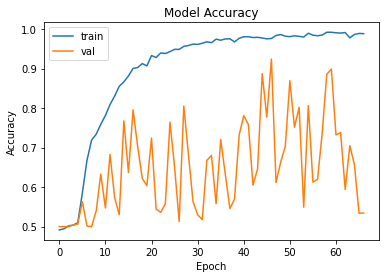

In [60]:
plot_training(results6)

# Step 4: Model Evaluation

Below, I load the final model and evaluate its performance on test data. This model achieves an accuracy of *insert accuracy* on test data.

### Performance on Test Data

In [61]:
# load test data
image_size = (512, 512)
batch_size = 32


test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1866 files belonging to 2 classes.


In [62]:
# load best performing model
best_model = tf.keras.models.load_model('/content/models/Model6/best_model_3.h5')

In [63]:
eval_results = best_model.evaluate(x=test_ds, verbose=1)

59/59 [==============================] - 3s 43ms/step - loss: 0.3050 - accuracy: 0.9266


### Performance on Hurricane Ian Data

In [38]:
!unzip gdrive/My\ Drive/data/hurricane-data.zip

Archive:  gdrive/My Drive/data/hurricane-data.zip
   creating: hurricane-data/
  inflating: hurricane-data/.DS_Store  
replace __MACOSX/hurricane-data/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: __MACOSX/hurricane-data/._.DS_Store  
   creating: hurricane-data/no-damage/
   creating: hurricane-data/damage/
  inflating: hurricane-data/no-damage/no-damage-1.png  
  inflating: __MACOSX/hurricane-data/no-damage/._no-damage-1.png  
  inflating: hurricane-data/no-damage/no-damage-2.png  
  inflating: __MACOSX/hurricane-data/no-damage/._no-damage-2.png  
  inflating: hurricane-data/no-damage/no-damage-3.png  
  inflating: __MACOSX/hurricane-data/no-damage/._no-damage-3.png  
  inflating: hurricane-data/no-damage/no-damage-4.png  
  inflating: __MACOSX/hurricane-data/no-damage/._no-damage-4.png  
  inflating: hurricane-data/no-damage/no-damage-5.png  
  inflating: __MACOSX/hurricane-data/no-damage/._no-damage-5.png  
  inflating: hurricane-data/damage/damage-4.png  
  inf

In [41]:
list_files('hurricane-data')

hurricane-data/
    no-damage/
    damage/


The below images are not from the same location. They are simply examples of `damage` and `no-damage` areas.



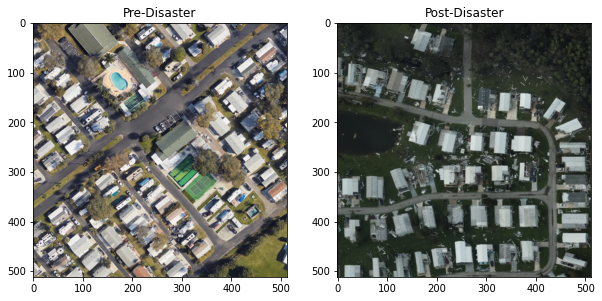

In [64]:
HURR_DIR = '/content/hurricane-data'

# load sample images
tile_path1 = os.path.join(HURR_DIR, 'no-damage' , 'no-damage-5.png')
tile1 = io.imread(tile_path1)

tile_path2 = os.path.join(HURR_DIR, 'damage' , 'damage-1.png')
tile2 = io.imread(tile_path2)

# plot pre-disaster image
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 2, 1)
plt.imshow(tile1)
plt.title("Pre-Disaster")
  
# splot post-disaster image
fig.add_subplot(1, 2, 2)
plt.imshow(tile2)
plt.title("Post-Disaster");

In [65]:
# path to dataset
hurr_path = os.path.join(DIR, 'test')

# load test data
image_size = (512, 512)
batch_size = 1


hurr_ds = tf.keras.preprocessing.image_dataset_from_directory(
    hurr_path,
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1866 files belonging to 2 classes.


In [67]:
eval_results = best_model.evaluate(x=hurr_ds, verbose=1)

1866/1866 [==============================] - 8s 4ms/step - loss: 0.3050 - accuracy: 0.9266
